In [ ]:
# ÌïúÍ∏Ä Ïïà Íπ®ÏßÄÍ≤å
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Layer
from tensorflow.keras import backend as K

In [ ]:
# Ìè∞Ìä∏ÏÑ§Ï†ï
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

In [ ]:
df = pd.read_csv('/content/all_features.csv', parse_dates=['DATE'], thousands=',')

In [ ]:
# ÏòàÏ∏° ÎåÄÏÉÅÍ≥º ÏûÖÎ†• ÌîºÏ≤ò Ï†ïÏùò
target_col = 'Ïõê/ÎØ∏Íµ≠Îã¨Îü¨(Îß§Îß§Í∏∞Ï§ÄÏú®)'
feature_cols = df.columns.drop(['DATE'])

In [ ]:
# ÌîºÏ≤ò Ï†ïÍ∑úÌôî
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[feature_cols])

In [ ]:
# ÏãúÌÄÄÏä§ ÏÉùÏÑ± Ìï®Ïàò
def create_multivariate_sequences(data, target_idx, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, target_idx])
    return np.array(X), np.array(y)

seq_len = 30
target_idx = list(feature_cols).index(target_col)

X, y = create_multivariate_sequences(scaled, target_idx, seq_len)

In [ ]:
# Train/Test Î∂ÑÎ¶¨
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Layer
from tensorflow.keras import backend as K

In [ ]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        # Í≥ÑÏÇ∞: Ï†êÏàò = tanh(XW + b)
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)  # ÏãúÏ†êÎ≥Ñ Í∞ÄÏ§ëÏπò
        output = x * a  # Í∞ÄÏ§ëÏπò Í≥±Ìï¥ÏÑú Ï∂úÎ†• ÏÉùÏÑ±
        return K.sum(output, axis=1)

In [ ]:
def build_lstm_attention_model(seq_len, n_features):
    inputs = Input(shape=(seq_len, n_features))
    x = LSTM(64, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)
    x = Attention()(x)  # Ïª§Ïä§ÌÖÄ Attention layer
    x = Dense(32, activation='relu')(x)
    output = Dense(1)(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
from keras.callbacks import EarlyStopping
model = build_lstm_attention_model(seq_len=seq_len, n_features=X.shape[2])
model.summary()

es = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, callbacks=[es])

Model: "functional"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer (InputLayer)        ‚îÇ (None, 30, 42)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm (LSTM)                     ‚îÇ (None, 30, 64)         ‚îÇ        27,392 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 30, 64)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ attention (Attention)           ‚îÇ (None, 64)             ‚îÇ            94 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 32)             ‚îÇ         2,080 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 1)              ‚îÇ            33 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 29,599 (115.62 KB)

 Trainable params: 29,599 (115.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
165/165 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 23ms/step - loss: 0.0080 - val_loss: 0.0017
Epoch 2/30
165/165 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 16ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 3/30
165/165 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 16ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 4/30
165/165 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 19ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 5/30
165/165 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 17ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 6/30
165/165 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 16ms/step - loss: 9.3606e-04 - val_loss: 0.0039
Epoch 7/30
165/165 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 17ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 8/30
165/165 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 23ms/step - loss: 9.2936

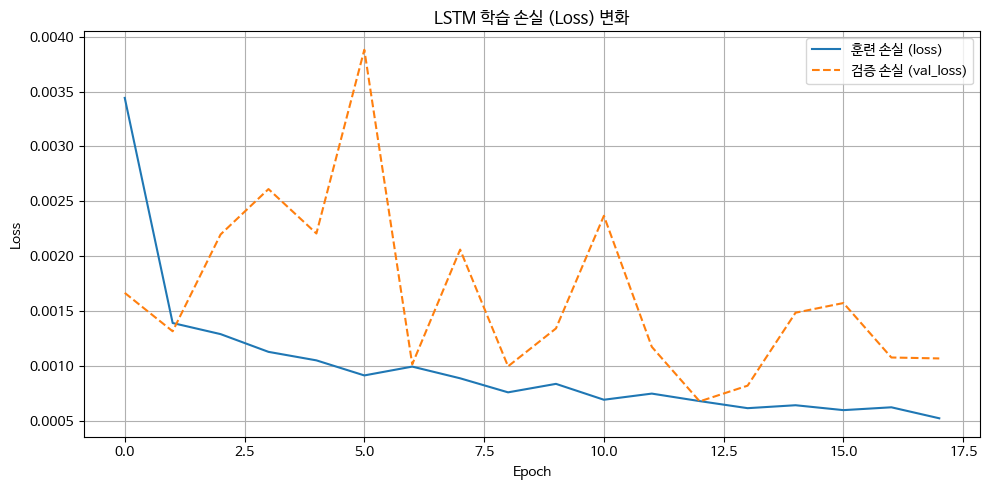

In [ ]:
# LSTM ÌïôÏäµ Í≥°ÏÑ† ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='ÌõàÎ†® ÏÜêÏã§ (loss)')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Í≤ÄÏ¶ù ÏÜêÏã§ (val_loss)', linestyle='--')

plt.title('LSTM ÌïôÏäµ ÏÜêÏã§ (Loss) Î≥ÄÌôî')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ÏòàÏ∏°
y_pred = model.predict(X_test)

46/46 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 13ms/step


In [ ]:
# Ïó≠Ï†ïÍ∑úÌôî: ÌÉÄÍπÉ Ïª¨ÎüºÎßå
target_scaler = MinMaxScaler()
target_scaler.fit(df[[target_col]])
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = target_scaler.inverse_transform(y_pred)

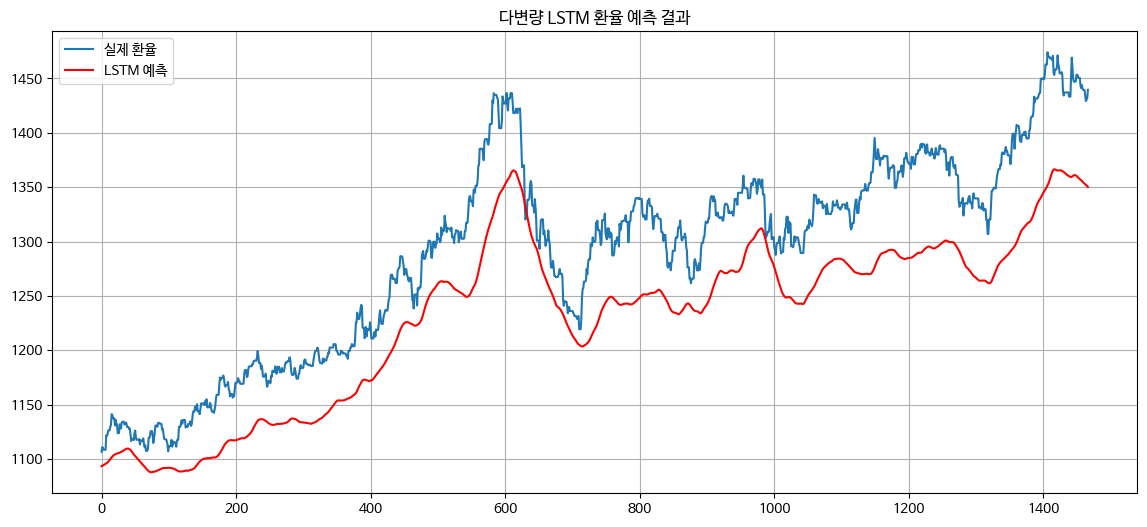

In [ ]:
# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(14, 6))
plt.plot(y_test_inv, label='Ïã§Ï†ú ÌôòÏú®')
plt.plot(y_pred_inv, label='LSTM ÏòàÏ∏°', color='red')
plt.title('Îã§Î≥ÄÎüâ LSTM ÌôòÏú® ÏòàÏ∏° Í≤∞Í≥º')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

mse = mean_squared_error(y_test, y_pred)
print(f'MSE : {mse}')

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE : {rmse}')

mae = mean_absolute_error(y_test, y_pred)
print(f'MAE : {mae}')

r2 = r2_score(y_test, y_pred)
print(f'R2 : {r2}')

# acc = accuracy_score(y_test, y_pred)
# print(f'Accuracy : {acc}')

MSE : 0.008783081776032951
RMSE : 0.09371809737736331
MAE : 0.08712822912112261
R2 : 0.5371511040711199


In [ ]:
n_future = 30  # ÏòàÏ∏°ÌïòÍ≥† Ïã∂ÏùÄ ÎØ∏Îûò Ïùº Ïàò
last_seq = X_test[-1]  # ÎßàÏßÄÎßâ ÏûÖÎ†• ÏãúÌÄÄÏä§ ÌïòÎÇò ÏÑ†ÌÉù (shape: [seq_len, n_features])
future_preds = []

curr_seq = last_seq.copy()

for _ in range(n_future):
    # (1) ÏûÖÎ†• shape ÎßûÏ∂∞Ï£ºÍ∏∞
    input_seq = curr_seq.reshape(1, seq_len, X.shape[2])

    # (2) ÏòàÏ∏°
    pred = model.predict(input_seq, verbose=0)[0][0]
    future_preds.append(pred)

    # (3) ÏòàÏ∏°Í∞íÏùÑ ÏãúÌÄÄÏä§Ïóê Î∂ôÏó¨ ÎÑ£Í∏∞
    next_step = curr_seq[1:].copy()  # Í∏∞Ï°¥ ÏãúÌÄÄÏä§ÏóêÏÑú Ï≤´ Î≤àÏß∏ ÎÇ† Ï†úÍ±∞
    new_row = curr_seq[-1].copy()    # ÎßàÏßÄÎßâ ÎÇ†Ïùò Î≥ÄÏàòÎì§ Î≥µÏÇ¨

    new_row[target_idx] = pred       # Ïö∞Î¶¨Í∞Ä ÏòàÏ∏°Ìïú Í∞íÎßå ÎåÄÏ≤¥!
    curr_seq = np.vstack([next_step, new_row])  # ÏÉàÎ°úÏö¥ ÏãúÌÄÄÏä§ Íµ¨ÏÑ±

In [ ]:
future_preds_inv = target_scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

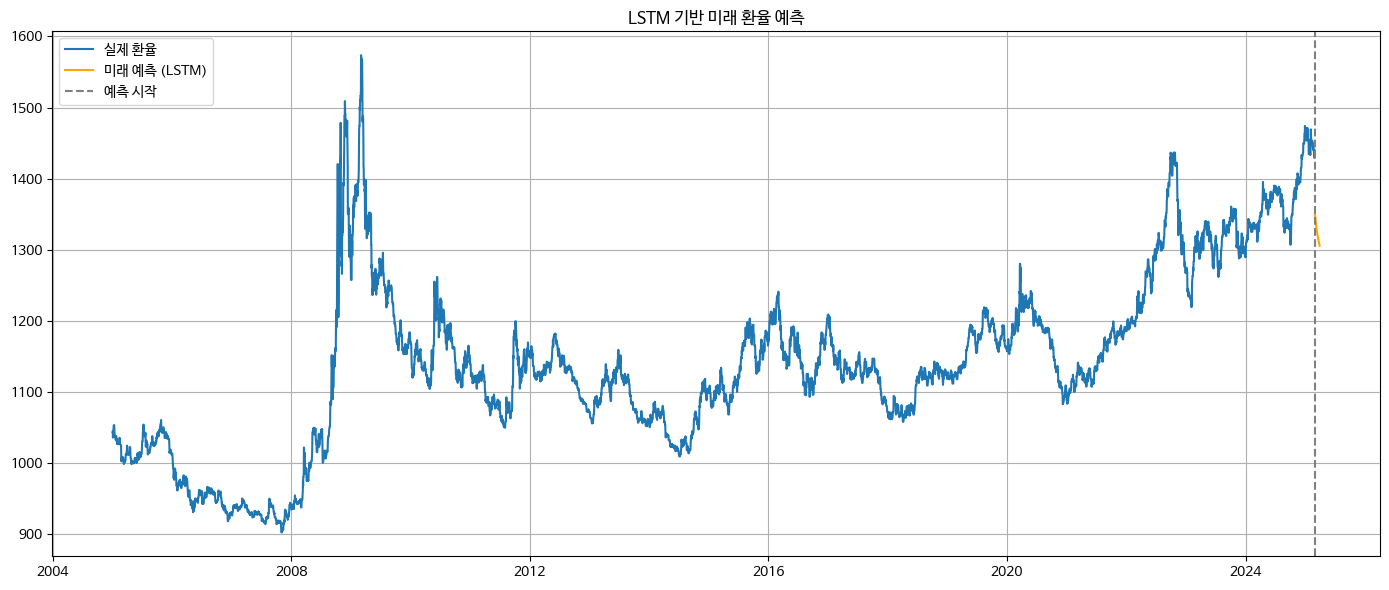

In [ ]:
# ÎßàÏßÄÎßâ ÎÇ†Ïßú Ïù¥ÌõÑÎ∂ÄÌÑ∞ ÎØ∏Îûò nÏùº ÏÉùÏÑ±
last_date = df['DATE'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future)

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(14, 6))
plt.plot(df['DATE'], df[target_col], label='Ïã§Ï†ú ÌôòÏú®')
plt.plot(future_dates, future_preds_inv, label='ÎØ∏Îûò ÏòàÏ∏° (LSTM)', color='orange')
plt.axvline(x=last_date, color='gray', linestyle='--', label='ÏòàÏ∏° ÏãúÏûë')
plt.legend()
plt.title('LSTM Í∏∞Î∞ò ÎØ∏Îûò ÌôòÏú® ÏòàÏ∏°')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
new = pd.read_csv('/content/new_0421.csv', parse_dates=['DATE'])
dollar0413 = new[new['DATE']>='2025-03-01'][['DATE','Ïõê/ÎØ∏Íµ≠Îã¨Îü¨(Îß§Îß§Í∏∞Ï§ÄÏú®)']]
dollar0413 = dollar0413.reset_index(drop=True)

In [ ]:
real = pd.DataFrame(future_preds_inv, columns=['ÏòàÏ∏°ÌôòÏú®'])
real = pd.concat([dollar0413, real], axis=1).dropna()
real['ÏòàÏ∏°Ï∞®Ïù¥'] = abs(real['Ïõê/ÎØ∏Íµ≠Îã¨Îü¨(Îß§Îß§Í∏∞Ï§ÄÏú®)']-real['ÏòàÏ∏°ÌôòÏú®'])
real

DATE  Ïõê/ÎØ∏Íµ≠Îã¨Îü¨(Îß§Îß§Í∏∞Ï§ÄÏú®)         ÏòàÏ∏°ÌôòÏú®        ÏòàÏ∏°Ï∞®Ïù¥
0  2025-03-01         1439.6  1350.139038   89.460962
1  2025-03-02         1439.6  1348.668213   90.931787
2  2025-03-03         1439.6  1346.774658   92.825342
3  2025-03-04         1458.7  1344.595703  114.104297
4  2025-03-05         1459.6  1342.309692  117.290308
5  2025-03-06         1456.0  1339.933594  116.066406
6  2025-03-07         1441.6  1337.504639  104.095361
7  2025-03-08         1441.6  1335.055664  106.544336
8  2025-03-09         1441.6  1332.853516  108.746484
9  2025-03-10         1446.3  1330.941040  115.358960
10 2025-03-11         1451.5  1329.214233  122.285767
11 2025-03-12         1457.9  1327.578003  130.321997
12 2025-03-13         1452.0  1326.015503  125.984497
13 2025-03-14         1451.9  1324.564331  127.335669
14 2025-03-15         1451.9  1323.108276  128.791724
15 2025-03-16         1451.9  1321.686401  130.213599
16 2025-03-17         1454.8  1320.303223  134.496777
17 2025-03-18         1448.0  1318.939453  129.060547
18 2025-03-19         1447.1  1317.563721  129.536279
19 2025-03-20         1452.3  1316.231079  136.068921
20 2025-03-21         1459.2  1315.007935  144.192065
21 2025-03-22         1459.2  1313.897461  145.302539
22 2025-03-23         1459.2  1312.781494  146.418506
23 2025-03-24         1466.9  1311.697998  155.202002
24 2025-03-25         1466.9  1310.678955  156.221045
25 2025-03-26         1469.6  1309.650146  159.949854
26 2025-03-27         1465.3  1308.629272  156.670728
27 2025-03-28         1466.8  1307.634521  159.165479
28 2025-03-29         1466.8  1306.561279  160.238721
29 2025-03-30         1466.8  1305.559570  161.240430

# Rolling Forecast ÏãúÍ≥ÑÏó¥ ÍµêÏ∞®Í≤ÄÏ¶ù

In [ ]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

In [ ]:
def build_lstm_attention_model(seq_len, n_features):
    inputs = Input(shape=(seq_len, n_features))
    x = LSTM(64, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)
    x = Attention()(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(1)(x)
    model = Model(inputs, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
df = pd.read_csv('/content/all_features.csv', parse_dates=['DATE'], thousands=',')
df = df.sort_values('DATE').dropna()

target_col = 'Ïõê/ÎØ∏Íµ≠Îã¨Îü¨(Îß§Îß§Í∏∞Ï§ÄÏú®)'
feature_cols = df.columns.drop(['DATE'])

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[feature_cols])
target_idx = list(feature_cols).index(target_col)

def create_sequences(data, target_idx, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, target_idx])
    return np.array(X), np.array(y)

seq_len = 20
X, y = create_sequences(scaled, target_idx, seq_len)

In [ ]:
mse_scores = []
mae_scores = []
r2_scores = []

initial_window = int(len(X) * 0.6)
step_size = int(len(X) * 0.1)

for i, start in enumerate(range(initial_window, len(X) - step_size, step_size)):
    print(f"\nüì¶ Fold {i+1}")
    X_train_cv, y_train_cv = X[:start], y[:start]
    X_val_cv, y_val_cv = X[start:start + step_size], y[start:start + step_size]

    model = build_lstm_attention_model(seq_len=seq_len, n_features=X.shape[2])
    model.fit(X_train_cv, y_train_cv, epochs=20, batch_size=32, verbose=0)

    y_pred_cv = model.predict(X_val_cv)

    mse = mean_squared_error(y_val_cv, y_pred_cv)
    mae = mean_absolute_error(y_val_cv, y_pred_cv)
    r2 = r2_score(y_val_cv, y_pred_cv)

    print(f"  ‚úÖ MSE: {mse:.4f}, MAE: {mae:.4f}, R¬≤: {r2:.4f}")

    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)

print("\nüìä Ï†ÑÏ≤¥ ÌèâÍ∑† ÏÑ±Îä•")
print(f"‚ñ∂ ÌèâÍ∑† MSE : {np.mean(mse_scores):.4f}")
print(f"‚ñ∂ ÌèâÍ∑† MAE : {np.mean(mae_scores):.4f}")
print(f"‚ñ∂ ÌèâÍ∑† R¬≤  : {np.mean(r2_scores):.4f}")


üì¶ Fold 1
23/23 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 17ms/step
  ‚úÖ MSE: 0.0004, MAE: 0.0157, R¬≤: 0.7445

üì¶ Fold 2
23/23 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 17ms/step
  ‚úÖ MSE: 0.0013, MAE: 0.0289, R¬≤: 0.6277

üì¶ Fold 3
23/23 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 15ms/step
  ‚úÖ MSE: 0.0033, MAE: 0.0493, R¬≤: 0.8042

üì¶ Fold 4
23/23 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 16ms/step
  ‚úÖ MSE: 0.0038, MAE: 0.0536, R¬≤: 0.2019

üìä Ï†ÑÏ≤¥ ÌèâÍ∑† ÏÑ±Îä•
‚ñ∂ ÌèâÍ∑† MSE : 0.0022
‚ñ∂ ÌèâÍ∑† MAE : 0.0369
‚ñ∂ ÌèâÍ∑† R¬≤  : 0.5946


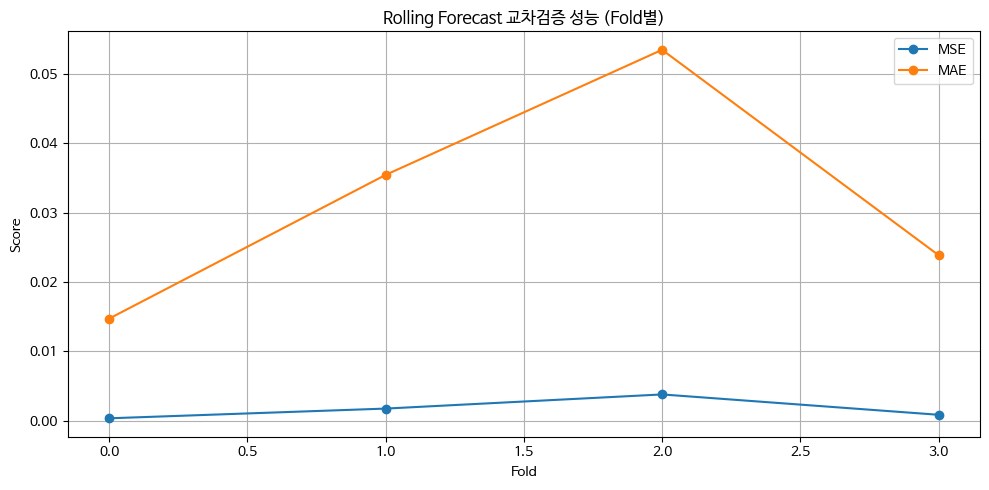

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(mse_scores, marker='o', label='MSE')
plt.plot(mae_scores, marker='o', label='MAE')
plt.title('Rolling Forecast ÍµêÏ∞®Í≤ÄÏ¶ù ÏÑ±Îä• (FoldÎ≥Ñ)')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Ï¢Ä Îçî Î≥µÏû°Ìïú Î™®Îç∏

In [ ]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)  # Ï†êÏàò Í≥ÑÏÇ∞
        a = K.softmax(e, axis=1)               # Í∞ÄÏ§ëÏπò ÏÉùÏÑ±
        output = x * a                         # Í∞ÄÏ§ëÏπò Í≥±Ìï¥ÏÑú ÏãúÏ†êÎ≥Ñ Í∞ïÏ°∞
        return K.sum(output, axis=1)           # ÏöîÏïΩ


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

def build_deep_lstm_attention_model(seq_len, n_features):
    inputs = Input(shape=(seq_len, n_features))

    x = LSTM(128, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)

    x = LSTM(64, return_sequences=True)(x)
    x = Dropout(0.3)(x)

    x = Attention()(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)

    output = Dense(1)(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model

In [ ]:
model = build_deep_lstm_attention_model(seq_len=30, n_features=X.shape[2])
model.summary()

from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[es],
    verbose=1
)

Model: "functional_12"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_12 (InputLayer)     ‚îÇ (None, 30, 42)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_16 (LSTM)                  ‚îÇ (None, 30, 128)        ‚îÇ        87,552 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_20 (Dropout)            ‚îÇ (None, 30, 128)        ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_17 (LSTM)                  ‚îÇ (None, 30, 64)         ‚îÇ        49,408 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_21 (Dropout)            ‚îÇ (None, 30, 64)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ attention_12 (Attention)        ‚îÇ (None, 64)             ‚îÇ            94 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_24 (Dense)                ‚îÇ (None, 64)             ‚îÇ         4,160 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_22 (Dropout)            ‚îÇ (None, 64)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_25 (Dense)                ‚îÇ (None, 1)              ‚îÇ            65 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 141,279 (551.87 KB)

 Trainable params: 141,279 (551.87 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
165/165 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 17s 72ms/step - loss: 0.0130 - val_loss: 0.0045
Epoch 2/100
165/165 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 20s 67ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 3/100
165/165 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 63ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 4/100
165/165 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22s 70ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 5/100
165/165 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 21s 74ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 6/100
165/165 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19s 64ms/step - loss: 0.0019 - val_loss: 9.7944e-04
Epoch 7/100
165/165 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 21s 70ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 8/100
165/165 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 20s 70ms/ste

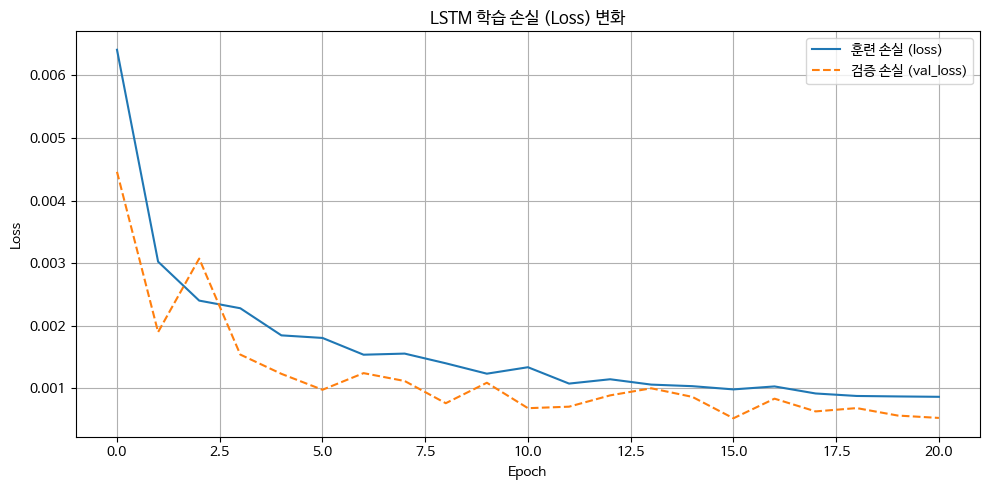

In [ ]:
# LSTM ÌïôÏäµ Í≥°ÏÑ† ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='ÌõàÎ†® ÏÜêÏã§ (loss)')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Í≤ÄÏ¶ù ÏÜêÏã§ (val_loss)', linestyle='--')

plt.title('LSTM ÌïôÏäµ ÏÜêÏã§ (Loss) Î≥ÄÌôî')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ÏòàÏ∏°
y_pred = model.predict(X_test)

46/46 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 40ms/step


In [ ]:
# Ïó≠Ï†ïÍ∑úÌôî: ÌÉÄÍπÉ Ïª¨ÎüºÎßå
target_scaler = MinMaxScaler()
target_scaler.fit(df[[target_col]])
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = target_scaler.inverse_transform(y_pred)

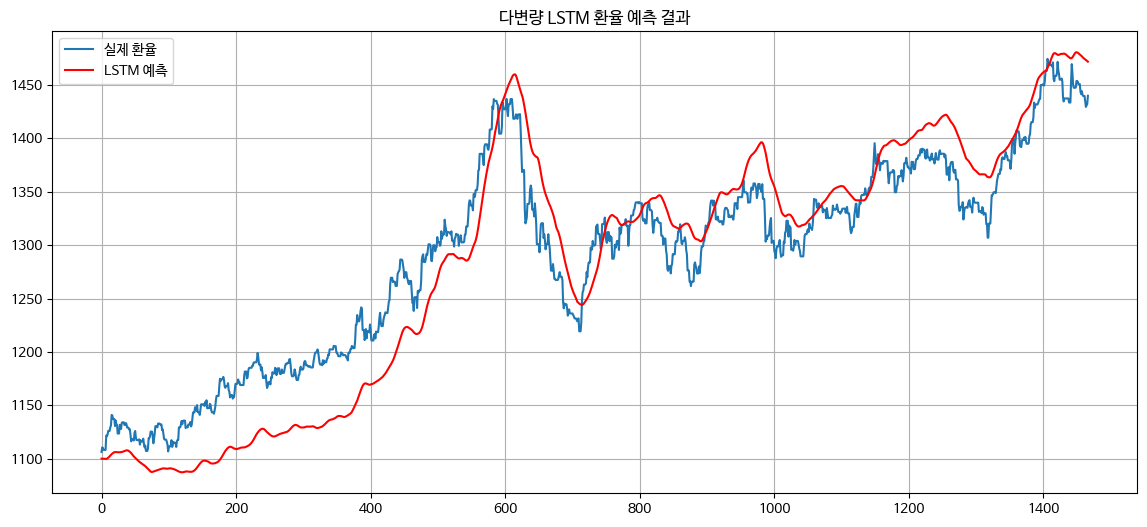

In [ ]:
# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(14, 6))
plt.plot(y_test_inv, label='Ïã§Ï†ú ÌôòÏú®')
plt.plot(y_pred_inv, label='LSTM ÏòàÏ∏°', color='red')
plt.title('Îã§Î≥ÄÎüâ LSTM ÌôòÏú® ÏòàÏ∏° Í≤∞Í≥º')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

mse = mean_squared_error(y_test, y_pred)
print(f'MSE : {mse}')

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE : {rmse}')

mae = mean_absolute_error(y_test, y_pred)
print(f'MAE : {mae}')

r2 = r2_score(y_test, y_pred)
print(f'R2 : {r2}')

# acc = accuracy_score(y_test, y_pred)
# print(f'Accuracy : {acc}')

MSE : 0.00338858613343842
RMSE : 0.05821156357149686
MAE : 0.05044936618032412
R2 : 0.8214290393035273


In [ ]:
n_future = 30  # ÏòàÏ∏°ÌïòÍ≥† Ïã∂ÏùÄ ÎØ∏Îûò Ïùº Ïàò
last_seq = X_test[-1]  # ÎßàÏßÄÎßâ ÏûÖÎ†• ÏãúÌÄÄÏä§ ÌïòÎÇò ÏÑ†ÌÉù (shape: [seq_len, n_features])
future_preds = []

curr_seq = last_seq.copy()

for _ in range(n_future):
    # (1) ÏûÖÎ†• shape ÎßûÏ∂∞Ï£ºÍ∏∞
    input_seq = curr_seq.reshape(1, 30, X.shape[2])

    # (2) ÏòàÏ∏°
    pred = model.predict(input_seq, verbose=0)[0][0]
    future_preds.append(pred)

    # (3) ÏòàÏ∏°Í∞íÏùÑ ÏãúÌÄÄÏä§Ïóê Î∂ôÏó¨ ÎÑ£Í∏∞
    next_step = curr_seq[1:].copy()  # Í∏∞Ï°¥ ÏãúÌÄÄÏä§ÏóêÏÑú Ï≤´ Î≤àÏß∏ ÎÇ† Ï†úÍ±∞
    new_row = curr_seq[-1].copy()    # ÎßàÏßÄÎßâ ÎÇ†Ïùò Î≥ÄÏàòÎì§ Î≥µÏÇ¨

    new_row[target_idx] = pred       # Ïö∞Î¶¨Í∞Ä ÏòàÏ∏°Ìïú Í∞íÎßå ÎåÄÏ≤¥!
    curr_seq = np.vstack([next_step, new_row])  # ÏÉàÎ°úÏö¥ ÏãúÌÄÄÏä§ Íµ¨ÏÑ±

In [ ]:
future_preds_inv = target_scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

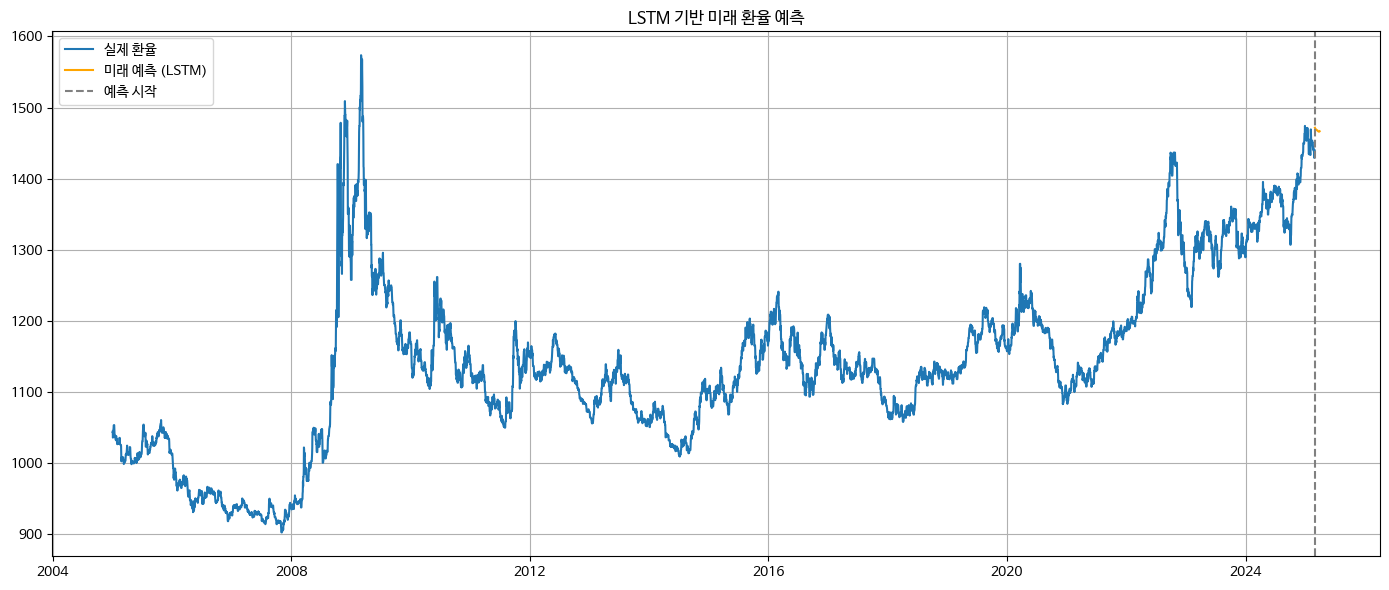

In [ ]:
# ÎßàÏßÄÎßâ ÎÇ†Ïßú Ïù¥ÌõÑÎ∂ÄÌÑ∞ ÎØ∏Îûò nÏùº ÏÉùÏÑ±
last_date = df['DATE'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future)

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(14, 6))
plt.plot(df['DATE'], df[target_col], label='Ïã§Ï†ú ÌôòÏú®')
plt.plot(future_dates, future_preds_inv, label='ÎØ∏Îûò ÏòàÏ∏° (LSTM)', color='orange')
plt.axvline(x=last_date, color='gray', linestyle='--', label='ÏòàÏ∏° ÏãúÏûë')
plt.legend()
plt.title('LSTM Í∏∞Î∞ò ÎØ∏Îûò ÌôòÏú® ÏòàÏ∏°')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
real = pd.DataFrame(future_preds_inv, columns=['ÏòàÏ∏°ÌôòÏú®'])
real = pd.concat([dollar0413, real], axis=1).dropna()
real['ÏòàÏ∏°Ï∞®Ïù¥'] = abs(real['Ïõê/ÎØ∏Íµ≠Îã¨Îü¨(Îß§Îß§Í∏∞Ï§ÄÏú®)']-real['ÏòàÏ∏°ÌôòÏú®'])
real

DATE  Ïõê/ÎØ∏Íµ≠Îã¨Îü¨(Îß§Îß§Í∏∞Ï§ÄÏú®)         ÏòàÏ∏°ÌôòÏú®       ÏòàÏ∏°Ï∞®Ïù¥
0  2025-03-01         1439.6  1471.505737  31.905737
1  2025-03-02         1439.6  1470.933228  31.333228
2  2025-03-03         1439.6  1470.432129  30.832129
3  2025-03-04         1458.7  1470.109131  11.409131
4  2025-03-05         1459.6  1469.888184  10.288184
5  2025-03-06         1456.0  1469.694702  13.694702
6  2025-03-07         1441.6  1469.199707  27.599707
7  2025-03-08         1441.6  1468.616577  27.016577
8  2025-03-09         1441.6  1468.216187  26.616187
9  2025-03-10         1446.3  1468.089478  21.789478
10 2025-03-11         1451.5  1468.118286  16.618286
11 2025-03-12         1457.9  1468.127686  10.227686
12 2025-03-13         1452.0  1468.115845  16.115845
13 2025-03-14         1451.9  1468.077637  16.177637
14 2025-03-15         1451.9  1467.967529  16.067529
15 2025-03-16         1451.9  1467.812500  15.912500
16 2025-03-17         1454.8  1467.581421  12.781421
17 2025-03-18         1448.0  1467.320435  19.320435
18 2025-03-19         1447.1  1467.010864  19.910864
19 2025-03-20         1452.3  1466.701294  14.401294
20 2025-03-21         1459.2  1466.524536   7.324536
21 2025-03-22         1459.2  1466.413330   7.213330
22 2025-03-23         1459.2  1466.254639   7.054639
23 2025-03-24         1466.9  1466.104858   0.795142
24 2025-03-25         1466.9  1466.073608   0.826392
25 2025-03-26         1469.6  1466.053955   3.546045
26 2025-03-27         1465.3  1466.073486   0.773486
27 2025-03-28         1466.8  1466.193359   0.606641
28 2025-03-29         1466.8  1466.329590   0.470410
29 2025-03-30         1466.8  1466.603760   0.196240

## ÏãúÍ≥ÑÏó¥ ÍµêÏ∞® Í≤ÄÏ¶ù

In [ ]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

In [ ]:
def build_deep_lstm_attention_model(seq_len, n_features):
    inputs = Input(shape=(seq_len, n_features))

    x = LSTM(128, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)

    x = LSTM(64, return_sequences=True)(x)
    x = Dropout(0.3)(x)

    x = Attention()(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)

    output = Dense(1)(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model

In [ ]:
# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
df = pd.read_csv('/content/all_features.csv', parse_dates=['DATE'], thousands=',')
df = df.sort_values('DATE').dropna()

target_col = 'Ïõê/ÎØ∏Íµ≠Îã¨Îü¨(Îß§Îß§Í∏∞Ï§ÄÏú®)'
feature_cols = df.columns.drop(['DATE'])

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[feature_cols])
target_idx = list(feature_cols).index(target_col)

def create_sequences(data, target_idx, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, target_idx])
    return np.array(X), np.array(y)

seq_len = 30
X, y = create_sequences(scaled, target_idx, seq_len)

In [ ]:
mse_scores = []
mae_scores = []
r2_scores = []

initial_window = int(len(X) * 0.6)
step_size = int(len(X) * 0.1)

for i, start in enumerate(range(initial_window, len(X) - step_size, step_size)):
    print(f"\nüì¶ Fold {i+1}")
    X_train_cv, y_train_cv = X[:start], y[:start]
    X_val_cv, y_val_cv = X[start:start + step_size], y[start:start + step_size]

    model = build_lstm_attention_model(seq_len=seq_len, n_features=X.shape[2])
    model.fit(X_train_cv, y_train_cv, epochs=20, batch_size=32, verbose=0)

    y_pred_cv = model.predict(X_val_cv)

    mse = mean_squared_error(y_val_cv, y_pred_cv)
    mae = mean_absolute_error(y_val_cv, y_pred_cv)
    r2 = r2_score(y_val_cv, y_pred_cv)

    print(f"  ‚úÖ MSE: {mse:.4f}, MAE: {mae:.4f}, R¬≤: {r2:.4f}")

    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)

print("\nüìä Ï†ÑÏ≤¥ ÌèâÍ∑† ÏÑ±Îä•")
print(f"‚ñ∂ ÌèâÍ∑† MSE : {np.mean(mse_scores):.4f}")
print(f"‚ñ∂ ÌèâÍ∑† MAE : {np.mean(mae_scores):.4f}")
print(f"‚ñ∂ ÌèâÍ∑† R¬≤  : {np.mean(r2_scores):.4f}")


üì¶ Fold 1
23/23 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 23ms/step
  ‚úÖ MSE: 0.0018, MAE: 0.0378, R¬≤: -0.2366

üì¶ Fold 2
23/23 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 18ms/step
  ‚úÖ MSE: 0.0019, MAE: 0.0378, R¬≤: 0.4581

üì¶ Fold 3
23/23 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 19ms/step
  ‚úÖ MSE: 0.0017, MAE: 0.0356, R¬≤: 0.8993

üì¶ Fold 4
23/23 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 26ms/step
  ‚úÖ MSE: 0.0027, MAE: 0.0415, R¬≤: 0.4233

üìä Ï†ÑÏ≤¥ ÌèâÍ∑† ÏÑ±Îä•
‚ñ∂ ÌèâÍ∑† MSE : 0.0020
‚ñ∂ ÌèâÍ∑† MAE : 0.0382
‚ñ∂ ÌèâÍ∑† R¬≤  : 0.3860
